In [1]:
# 1. Các thư viện cần thiết
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.varmax import VARMAX
from pmdarima.arima import auto_arima
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

In [2]:
# 2. Đọc file dữ liệu chứng khoán BIDV và chia tập train test theo tỉ lệ 8:2
df = pd.read_csv('BIDV.csv')
df = df[['Close', 'High']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

train_size = int(0.8 * len(df))
test_size = len(df) - train_size

train_data = df[:train_size]
test_data = df[train_size:]

In [3]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

# Tìm mô hình ARIMA phù hợp nhất bằng auto_arima 
auto_arima(train_data['Close'], trace=True, error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=16662.082, Time=0.48 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=16655.249, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=16656.474, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=16656.454, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=16653.785, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=16658.392, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.660 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [4]:
model = VARMAX(train_data, order=(1, 1))
model_fit = model.fit(maxiter=1000, disp=False)

C:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


In [5]:
# 4. Quá trình testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
close_pred = model_fit.forecast(steps=len(y_test))
y_pred = close_pred['Close'].to_numpy()

In [6]:
# 5. Quá trình tạo index predict 90 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+90, step=1)

# Tạo một mảng gồm 90 số nguyên liên tiếp bắt đầu từ last_index
x_next_90_days = np.array(range(last_index+1, last_index+91)).reshape(-1, 1)

# Dự đoán giá đóng cho 90 ngày tiếp theo
close_next_90_days = model_fit.forecast(steps=len(x_next_90_days))

y_next_90_days = close_next_90_days['Close'].to_numpy()

# In ra giá đóng đã được dự đoán trong 90 ngày tiếp theo
print('Predicted closing prices for the next 90 days:')
print(y_next_90_days)

Predicted closing prices for the next 90 days:
[39818.06198779 39740.23149051 39687.24792166 39645.10351427
 39607.72405541 39572.47544913 39538.2152901  39504.44799475
 39470.95845247 39437.65317103 39404.49139455 39371.45523526
 39338.53672207 39305.73218465 39273.03981828 39240.45862792
 39207.98797035 39175.62735559 39143.37636085 39111.23459318
 39079.20167329 39047.27722848 39015.46088968 38983.75229002
 38952.15106434 38920.65684891 38889.26928129 38857.98800032
 38826.81264607 38795.74285985 38764.77828416 38733.91856274
 38703.16334052 38672.51226364 38641.96497943 38611.52113643
 38581.18038436 38550.94237412 38520.8067578  38490.77318867
 38460.84132117 38431.01081091 38401.28131468 38371.6524904
 38342.12399718 38312.69549526 38283.36664606 38254.13711213
 38225.00655714 38195.97464594 38167.04104449 38138.20541989
 38109.46744037 38080.82677526 38052.28309504 38023.83607129
 37995.48537671 37967.2306851  37939.07167137 37911.00801152
 37883.03938268 37855.16546302 37827.38

In [7]:
# 6. Tính độ đo RMSE
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Testing RMSE:', test_rmse)

Testing RMSE: 9806.60146753705


In [8]:
# 7. Đánh giá độ chính xác thuật toán bằng MAPE
test_mape = np.mean(np.abs(y_pred - y_test)/np.abs(y_test))*100
print('Testing MAPE:', test_mape)

Testing MAPE: 15.190427527533759


In [9]:
# 8. Đánh giá độ chính xác thuật toán bằng MAE
test_mae = np.mean(abs(y_pred - y_test))
print('Testing MAE:', test_mae)

Testing MAE: 7267.226969188805


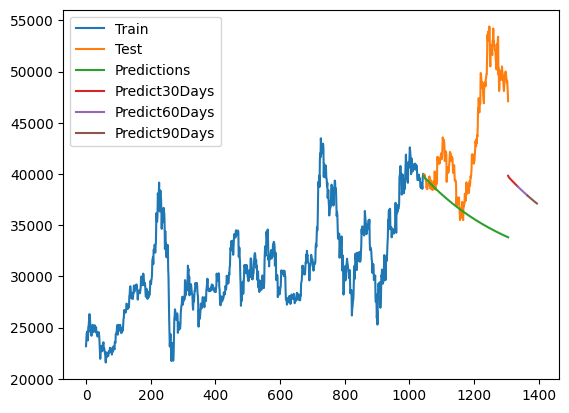

In [10]:
# 9.Vẽ hình
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(last_data[0:30],y_next_90_days[0:30])
plt.plot(last_data[30:60],y_next_90_days[30:60])
plt.plot(last_data[60:90],y_next_90_days[60:90])
plt.legend(['Train', 'Test', 'Predictions','Predict30Days', 'Predict60Days', 'Predict90Days'])
plt.show()

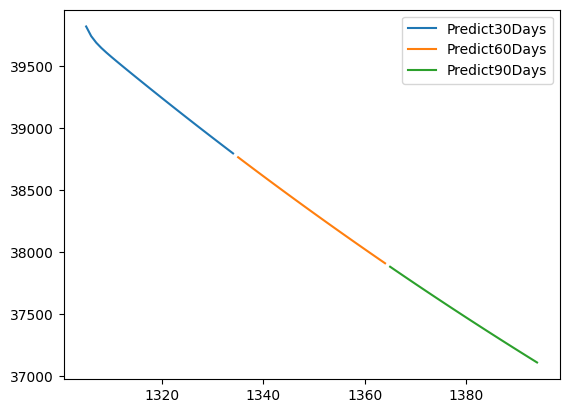

In [11]:
plt.plot(last_data[0:30],y_next_90_days[0:30])
plt.plot(last_data[30:60],y_next_90_days[30:60])
plt.plot(last_data[60:90],y_next_90_days[60:90])
plt.legend(['Predict30Days', 'Predict60Days', 'Predict90Days'])
plt.show()